### Setup

In [57]:
import gc
import pickle

from feature_engine.creation import CyclicalFeatures
from feature_engine.encoding import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
import xgboost as xgb

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeRegressor

In [58]:
# plot style
plt.style.use(['science','no-latex'])

# plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['savefig.format'] = 'eps'
plt.rcParams['figure.figsize'] = (6, 3)

# display all rows and columns when printing in the notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Data

### Load data

In [3]:
# dtypes = {
#     'DayOfWeek':                       int,
#     'FlightDate':                      'string',
#     'IATA_CODE_Reporting_Airline':     'string',
#     'Tail_Number':                     'string',
#     'Flight_Number_Reporting_Airline': int,
#     'OriginAirportID':                 int,
#     'Origin':                          'string',
#     'OriginState':                     'string',
#     'DestAirportID':                   int,
#     'Dest':                            'string',
#     'DestState':                       'string',
#     'CRSDepTime':                      int,
#     'DepTime':                         int,
#     'DepDelayMinutes':                 int,
#     'CRSArrTime':                      int,
#     'ArrTime':                         int,
#     'ArrDelayMinutes':                 int,
#     'Cancelled':                       int,
#     'CancellationCode':                'string',
#     'Diverted':                        int,
#     'CRSElapsedTime':                  int,
#     'ActualElapsedTime':               int,
#     'AirTime':                         int,
#     'CarrierDelay':                    int,
#     'WeatherDelay':                    int,
#     'NASDelay':                        int,
#     'SecurityDelay':                   int,
#     'LateAircraftDelay':               int,
#     'CRSDepHour':                      int,
#     'OriginTz':                        'string',
#     'DestTz':                          'string',
#     'CRSArrDateTime':                  'string',
#     'CRSArrDate':                      'string',
#     'CRSArrHour':                      int,
#     'o_temperature_2m':                float,
#     'o_relative_humidity_2m':          float,
#     'o_dew_point_2m':                  float,
#     'o_apparent_temperature':          float,
#     'o_precipitation':                 float,
#     'o_rain':                          float,
#     'o_snowfall':                      float,
#     'o_snow_depth':                    float,
#     'o_weather_code':                  float,
#     'o_surface_pressure':              float,
#     'o_cloud_cover':                   float,
#     'o_cloud_cover_low':               float,
#     'o_cloud_cover_mid':               float,
#     'o_cloud_cover_high':              float,
#     'o_wind_speed_10m':                float,
#     'o_wind_speed_100m':               float,
#     'o_wind_gusts_10m':                float,
#     'o_shortwave_radiation':           float,
#     'o_direct_radiation':              float,
#     'o_diffuse_radiation':             float,
#     'o_direct_normal_irradiance':      float,
#     'o_terrestrial_radiation':         float,
#     'o_airport':                       'string',
#     'o_day':                           'string',
#     'o_hour':                          int,
#     'd_temperature_2m':                float,
#     'd_relative_humidity_2m':          float,
#     'd_dew_point_2m':                  float,
#     'd_apparent_temperature':          float,
#     'd_precipitation':                 float,
#     'd_rain':                          float,
#     'd_snowfall':                      float,
#     'd_snow_depth':                    float,
#     'd_weather_code':                  float,
#     'd_surface_pressure':              float,
#     'd_cloud_cover':                   float,
#     'd_cloud_cover_low':               float,
#     'd_cloud_cover_mid':               float,
#     'd_cloud_cover_high':              float,
#     'd_wind_speed_10m':                float,
#     'd_wind_speed_100m':               float,
#     'd_wind_gusts_10m':                float,
#     'd_shortwave_radiation':           float,
#     'd_direct_radiation':              float,
#     'd_diffuse_radiation':             float,
#     'd_direct_normal_irradiance':      float,
#     'd_terrestrial_radiation':         float,
#     'd_airport':                       'string',
#     'd_day':                           'string',
#     'd_hour':                          int
# }

def load_data():
    files = [
        'data/weather-joined/full-w-2017.csv',
        'data/weather-joined/full-w-2018.csv',
        'data/weather-joined/full-w-2019.csv',
    ]

    dfs = [pd.read_csv(f, low_memory=False) for f in files]
    return pd.concat(dfs, ignore_index=True)

In [4]:
df = load_data()

In [5]:
df.shape[0]
df.isnull().sum()

DayOfWeek                                 0
FlightDate                                0
IATA_CODE_Reporting_Airline               0
Tail_Number                           39300
Flight_Number_Reporting_Airline           0
OriginAirportID                           0
Origin                                    0
OriginState                               0
DestAirportID                             0
Dest                                      0
DestState                                 0
CRSDepTime                                0
DepTime                              299182
DepDelayMinutes                           0
CRSArrTime                                0
ArrTime                              317019
ArrDelayMinutes                      357438
Cancelled                                 0
CancellationCode                   18817409
Diverted                                  0
CRSElapsedTime                            0
ActualElapsedTime                    357089
AirTime                         

In [6]:
df.head()

,DayOfWeek,FlightDate,IATA_CODE_Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,OriginAirportID,Origin,OriginState,DestAirportID,Dest,DestState,CRSDepTime,DepTime,DepDelayMinutes,CRSArrTime,ArrTime,ArrDelayMinutes,Cancelled,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,CRSDepHour,OriginTz,DestTz,CRSArrDateTime,CRSArrDate,CRSArrHour,o_temperature_2m,o_relative_humidity_2m,o_dew_point_2m,o_apparent_temperature,o_precipitation,o_rain,o_snowfall,o_snow_depth,o_weather_code,o_surface_pressure,o_cloud_cover,o_cloud_cover_low,o_cloud_cover_mid,o_cloud_cover_high,o_wind_speed_10m,o_wind_speed_100m,o_wind_gusts_10m,o_shortwave_radiation,o_direct_radiation,o_diffuse_radiation,o_direct_normal_irradiance,o_terrestrial_radiation,o_airport,o_day,o_hour,d_temperature_2m,d_relative_humidity_2m,d_dew_point_2m,d_apparent_temperature,d_precipitation,d_rain,d_snowfall,d_snow_depth,d_weather_code,d_surface_pressure,d_cloud_cover,d_cloud_cover_low,d_cloud_cover_mid,d_cloud_cover_high,d_wind_speed_10m,d_wind_speed_100m,d_wind_gusts_10m,d_shortwave_radiation,d_direct_radiation,d_diffuse_radiation,d_direct_normal_irradiance,d_terrestrial_radiation,d_airport,d_day,d_hour
0,7,2017-01-01,AA,N787AA,1,12478,JFK,NY,12892,LAX,CA,800,831.0,31.0,1142,1209.0,27.0,0,NaN,0,402.0,398.0,347.0,27.0,0.0,0.0,0.0,0.0,7,America/New_York,America/Los_Angeles,2017-01-01 12:09:00-08:00,2017-01-01,11,42.9953,55.499237,28.145300,32.976753,0.011811,0.011811,0.0,0.0,51.0,1013.05206,52.800000,0.0,80.0,16.0,13.350974,22.423624,25.278101,0.0,0.0,0.0,0.0,0.0,JFK,2017-01-01,7.0,43.743202,81.152390,38.3432,37.638832,0.000000,0.000000,0.0,0.0,0.0,1006.27985,0.000000,0.0,0.0,0.0,7.993950,12.424918,11.632400,0.0,0.0,0.0,0.0,0.0,LAX,2017-01-01,11.0
1,1,2017-01-02,AA,N788AA,1,12478,JFK,NY,12892,LAX,CA,800,757.0,0.0,1142,1154.0,12.0,0,NaN,0,402.0,417.0,362.0,NaN,NaN,NaN,NaN,NaN,7,America/New_York,America/Los_Angeles,2017-01-02 11:38:00-08:00,2017-01-02,11,32.1953,78.183426,26.165300,25.610653,0.000000,0.000000,0.0,0.0,1.0,1031.14220,29.400002,0.0,0.0,98.0,4.611693,12.112896,8.053200,0.0,0.0,0.0,0.0,0.0,JFK,2017-01-02,7.0,51.483200,82.565260,46.3532,48.706870,0.000000,0.000000,0.0,0.0,3.0,1010.93726,100.000000,100.0,63.0,90.0,4.320365,6.521919,6.934699,0.0,0.0,0.0,0.0,0.0,LAX,2017-01-02,11.0
2,2,2017-01-03,AA,N783AA,1,12478,JFK,NY,12892,LAX,CA,800,754.0,0.0,1142,1118.0,0.0,0,NaN,0,402.0,384.0,354.0,NaN,NaN,NaN,NaN,NaN,7,America/New_York,America/Los_Angeles,2017-01-03 11:38:00-08:00,2017-01-03,11,41.6453,92.292366,39.575300,34.548943,0.003937,0.003937,0.0,0.0,51.0,1022.94904,100.000000,100.0,96.0,100.0,10.915552,18.522575,19.461899,0.0,0.0,0.0,0.0,0.0,JFK,2017-01-03,7.0,48.963200,91.282074,46.5332,45.944515,0.000000,0.000000,0.0,0.0,1.0,1016.18290,42.300003,9.0,7.0,100.0,5.002084,8.204028,7.605800,0.0,0.0,0.0,0.0,0.0,LAX,2017-01-03,11.0
3,3,2017-01-04,AA,N799AA,1,12478,JFK,NY,12892,LAX,CA,800,757.0,0.0,1142,1132.0,0.0,0,NaN,0,402.0,395.0,360.0,NaN,NaN,NaN,NaN,NaN,7,America/New_York,America/Los_Angeles,2017-01-04 11:38:00-08:00,2017-01-04,11,40.2953,96.561200,39.395300,34.806420,0.000000,0.000000,0.0,0.0,3.0,997.55470,90.000000,100.0,0.0,0.0,7.024322,11.106429,12.527200,0.0,0.0,0.0,0.0,0.0,JFK,2017-01-04,7.0,48.963200,86.143740,45.0032,45.648950,0.000000,0.000000,0.0,0.0,0.0,1015.48670,19.200000,20.0,2.0,0.0,4.803042,1.432379,6.039900,0.0,0.0,0.0,0.0,0.0,LAX,2017-01-04,11.0
4,4,2017-01-05,AA,N788AA,1,12478,JFK,NY,12892,LAX,CA,800,753.0,0.0,1142,1141.0,0.0,0,NaN,0,402.0,408.0,387.0,NaN,NaN,NaN,NaN,NaN,7,America/New_York,America/Los_Angeles,2017-01-05 11:38:00-08:00,2017-01-05,11,29.4053,47.067635,11.675299,17.958977,0.000000,0.000000,0.0,0.0,0.0,1009.74590,0.000000,0.0,0.0,0.0,12.821347,20.341946,25.501799,0.0,0.0,0.0,0.0,0.0,JFK,2017-01-05,7.0,56.073200,91.537660,53.6432,54.387240,0.023622,0.023622,0.0,0.0,53.0,1011.38280,100.000000,100.0,91.0,0.0,6.673613,7.915314,12.303500,0.0,0.0,0.0,0.0,0

### Clean

In [7]:
def clean_data(df):
    # convert string timestamps to datetime objects
    datetime_cols = ['FlightDate', 'CRSArrDateTime', 'CRSArrDate', 'o_day', 'd_day']
    for col in datetime_cols:
        df[col] = pd.to_datetime(df[col])

    # drop rows that have cancelled or diverted flights
    df = df.drop(df[(df['Cancelled'] == 1) | (df['Diverted'] == 1)].index)

    # fill 0s for columns that make sense
    cols = ["CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", "o_snow_depth", "d_snow_depth"]
    df[cols] = df[cols].fillna(value=0)

    # we won't use `CancellationCode`, so drop it
    df = df.drop('CancellationCode', axis=1)

    # drop rows that have `NaN`s for the other columns.
    df = df.dropna()
    
    return df

In [8]:
df = clean_data(df)
df.shape[0]

/tmp/ipykernel_344015/1114253781.py:5: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df[col] = pd.to_datetime(df[col])


18770048

In [9]:
df.isnull().sum()

DayOfWeek                          0
FlightDate                         0
IATA_CODE_Reporting_Airline        0
Tail_Number                        0
Flight_Number_Reporting_Airline    0
OriginAirportID                    0
Origin                             0
OriginState                        0
DestAirportID                      0
Dest                               0
DestState                          0
CRSDepTime                         0
DepTime                            0
DepDelayMinutes                    0
CRSArrTime                         0
ArrTime                            0
ArrDelayMinutes                    0
Cancelled                          0
Diverted                           0
CRSElapsedTime                     0
ActualElapsedTime                  0
AirTime                            0
CarrierDelay                       0
WeatherDelay                       0
NASDelay                           0
SecurityDelay                      0
LateAircraftDelay                  0
C

In [10]:
df.head()

,DayOfWeek,FlightDate,IATA_CODE_Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,OriginAirportID,Origin,OriginState,DestAirportID,Dest,DestState,CRSDepTime,DepTime,DepDelayMinutes,CRSArrTime,ArrTime,ArrDelayMinutes,Cancelled,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,CRSDepHour,OriginTz,DestTz,CRSArrDateTime,CRSArrDate,CRSArrHour,o_temperature_2m,o_relative_humidity_2m,o_dew_point_2m,o_apparent_temperature,o_precipitation,o_rain,o_snowfall,o_snow_depth,o_weather_code,o_surface_pressure,o_cloud_cover,o_cloud_cover_low,o_cloud_cover_mid,o_cloud_cover_high,o_wind_speed_10m,o_wind_speed_100m,o_wind_gusts_10m,o_shortwave_radiation,o_direct_radiation,o_diffuse_radiation,o_direct_normal_irradiance,o_terrestrial_radiation,o_airport,o_day,o_hour,d_temperature_2m,d_relative_humidity_2m,d_dew_point_2m,d_apparent_temperature,d_precipitation,d_rain,d_snowfall,d_snow_depth,d_weather_code,d_surface_pressure,d_cloud_cover,d_cloud_cover_low,d_cloud_cover_mid,d_cloud_cover_high,d_wind_speed_10m,d_wind_speed_100m,d_wind_gusts_10m,d_shortwave_radiation,d_direct_radiation,d_diffuse_radiation,d_direct_normal_irradiance,d_terrestrial_radiation,d_airport,d_day,d_hour
0,7,2017-01-01,AA,N787AA,1,12478,JFK,NY,12892,LAX,CA,800,831.0,31.0,1142,1209.0,27.0,0,0,402.0,398.0,347.0,27.0,0.0,0.0,0.0,0.0,7,America/New_York,America/Los_Angeles,2017-01-01 12:09:00-08:00,2017-01-01,11,42.9953,55.499237,28.145300,32.976753,0.011811,0.011811,0.0,0.0,51.0,1013.05206,52.800000,0.0,80.0,16.0,13.350974,22.423624,25.278101,0.0,0.0,0.0,0.0,0.0,JFK,2017-01-01,7.0,43.743202,81.152390,38.3432,37.638832,0.000000,0.000000,0.0,0.0,0.0,1006.27985,0.000000,0.0,0.0,0.0,7.993950,12.424918,11.632400,0.0,0.0,0.0,0.0,0.0,LAX,2017-01-01,11.0
1,1,2017-01-02,AA,N788AA,1,12478,JFK,NY,12892,LAX,CA,800,757.0,0.0,1142,1154.0,12.0,0,0,402.0,417.0,362.0,0.0,0.0,0.0,0.0,0.0,7,America/New_York,America/Los_Angeles,2017-01-02 11:38:00-08:00,2017-01-02,11,32.1953,78.183426,26.165300,25.610653,0.000000,0.000000,0.0,0.0,1.0,1031.14220,29.400002,0.0,0.0,98.0,4.611693,12.112896,8.053200,0.0,0.0,0.0,0.0,0.0,JFK,2017-01-02,7.0,51.483200,82.565260,46.3532,48.706870,0.000000,0.000000,0.0,0.0,3.0,1010.93726,100.000000,100.0,63.0,90.0,4.320365,6.521919,6.934699,0.0,0.0,0.0,0.0,0.0,LAX,2017-01-02,11.0
2,2,2017-01-03,AA,N783AA,1,12478,JFK,NY,12892,LAX,CA,800,754.0,0.0,1142,1118.0,0.0,0,0,402.0,384.0,354.0,0.0,0.0,0.0,0.0,0.0,7,America/New_York,America/Los_Angeles,2017-01-03 11:38:00-08:00,2017-01-03,11,41.6453,92.292366,39.575300,34.548943,0.003937,0.003937,0.0,0.0,51.0,1022.94904,100.000000,100.0,96.0,100.0,10.915552,18.522575,19.461899,0.0,0.0,0.0,0.0,0.0,JFK,2017-01-03,7.0,48.963200,91.282074,46.5332,45.944515,0.000000,0.000000,0.0,0.0,1.0,1016.18290,42.300003,9.0,7.0,100.0,5.002084,8.204028,7.605800,0.0,0.0,0.0,0.0,0.0,LAX,2017-01-03,11.0
3,3,2017-01-04,AA,N799AA,1,12478,JFK,NY,12892,LAX,CA,800,757.0,0.0,1142,1132.0,0.0,0,0,402.0,395.0,360.0,0.0,0.0,0.0,0.0,0.0,7,America/New_York,America/Los_Angeles,2017-01-04 11:38:00-08:00,2017-01-04,11,40.2953,96.561200,39.395300,34.806420,0.000000,0.000000,0.0,0.0,3.0,997.55470,90.000000,100.0,0.0,0.0,7.024322,11.106429,12.527200,0.0,0.0,0.0,0.0,0.0,JFK,2017-01-04,7.0,48.963200,86.143740,45.0032,45.648950,0.000000,0.000000,0.0,0.0,0.0,1015.48670,19.200000,20.0,2.0,0.0,4.803042,1.432379,6.039900,0.0,0.0,0.0,0.0,0.0,LAX,2017-01-04,11.0
4,4,2017-01-05,AA,N788AA,1,12478,JFK,NY,12892,LAX,CA,800,753.0,0.0,1142,1141.0,0.0,0,0,402.0,408.0,387.0,0.0,0.0,0.0,0.0,0.0,7,America/New_York,America/Los_Angeles,2017-01-05 11:38:00-08:00,2017-01-05,11,29.4053,47.067635,11.675299,17.958977,0.000000,0.000000,0.0,0.0,0.0,1009.74590,0.000000,0.0,0.0,0.0,12.821347,20.341946,25.501799,0.0,0.0,0.0,0.0,0.0,JFK,2017-01-05,7.0,56.073200,91.537660,53.6432,54.387240,0.023622,0.023622,0.0,0.0,53.0,1011.38280,100.000000,100.0,91.0,0.0,6.673613,7.915314,12.303500,0.0,0.0,0.0,0.0,0.0,LAX,2017-01-05,11.0


### Prepare data

In [11]:
# true/false field that indicates if it is a weekend
def is_weekend(df):
    df['weekend'] = df['DayOfWeek'] >= 6
    return df

# extract month from the date
# assumption: df[col] is of type datetime
def get_month(col, pref):
    def inner(df):
        df[f"{pref}_month"] = df[col].dt.month
        return df

    return inner


# extract day of month from the date
# assumption: df[col] is of type datetime
def get_day_of_month(col, pref):
    def inner(df):
        df[f"{pref}_day_of_month"] = df[col].dt.day
        return df

    return inner


### Merge other datasets

Add cluster labels to each of the origin and destination airports

In [12]:
def add_cluster_labels(df):
    cluster_labels = pd.read_csv('latitude_longitude_cluster.csv')
    clustered = pd.merge(df, cluster_labels.add_prefix('o_'), left_on=['Origin'], right_on=['o_IATA_CODE'], how='left')
    clustered = pd.merge(clustered, cluster_labels.add_prefix('d_'), left_on=['Dest'], right_on=['d_IATA_CODE'], how='left')
    return clustered

In [13]:
def add_weather_features(df):
    avg_daily_weather = pd.read_csv("data/weather-joined/average_daily_weather.csv")
    avg_daily_weather = avg_daily_weather.fillna(value=0)

    df = pd.merge(df, avg_daily_weather.add_prefix('o_'),
                  left_on=['Origin', 'o_month', 'o_day_of_month'],
                  right_on=['o_airport', 'o_month', 'o_day'],
                  how='left')
    df['o_temp_delta'] = df['o_temperature_2m'] - df['o_temperature_2m_mean']
    df['o_humidity_delta'] = df['o_relative_humidity_2m'] - df['o_relative_humidity_2m_mean']
    df['o_dew_point_delta'] = df['o_dew_point_2m'] - df['o_dew_point_2m_mean']
    df['o_precipitation_delta'] = df['o_precipitation'] - df['o_precipitation_sum']

    df = pd.merge(df, avg_daily_weather.add_prefix('d_'),
                  left_on=['Dest', 'd_month', 'd_day_of_month'],
                  right_on=['d_airport', 'd_month', 'd_day'],
                  how='left')
    df['d_temp_delta'] = df['d_temperature_2m'] - df['d_temperature_2m_mean']
    df['d_humidity_delta'] = df['d_relative_humidity_2m'] - df['d_relative_humidity_2m_mean']
    df['d_dew_point_delta'] = df['d_dew_point_2m'] - df['d_dew_point_2m_mean']
    df['d_precipitation_delta'] = df['d_precipitation'] - df['d_precipitation_sum']

    return df

In [14]:
# Balance the dataset by sampling equal number of non-delay records as delay records
def balance_dataset(df):
    delay_mask = (df['NASDelay'] > 0) | (df['WeatherDelay'] > 0)
    delay_df = df[delay_mask]
    non_delay_df = df[~delay_mask]

    # print(delay_df.shape)
    # print(non_delay_df.shape)

    num_delay_records = delay_df.shape[0]
    df = pd.concat([delay_df, non_delay_df.sample(num_delay_records, replace=False)])
    
    return df

In [15]:
def apply_funcs(df, funcs):
    for f in funcs:
        df = f(df)
    return df

df = apply_funcs(df,
    [
            # indicate if it is a weekend
        is_weekend,

            # extract day of month from flight date
        get_day_of_month('o_day', 'o'),
        get_day_of_month('d_day', 'd'),            # extract month from flight date
        get_month('o_day', 'o'),
        get_month('d_day', 'd'),

        ])


In [16]:
df = add_cluster_labels(df)

In [17]:
df = add_weather_features(df)

In [18]:
data_2 = df[df['o_cluster_labels'] == 1]

<Axes: xlabel='o_month', ylabel='o_temp_delta'>

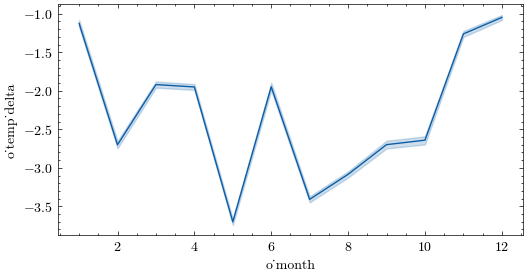

In [19]:
sns.lineplot(data = data_2, x=data_2['o_month'], y=data_2['o_temp_delta'])

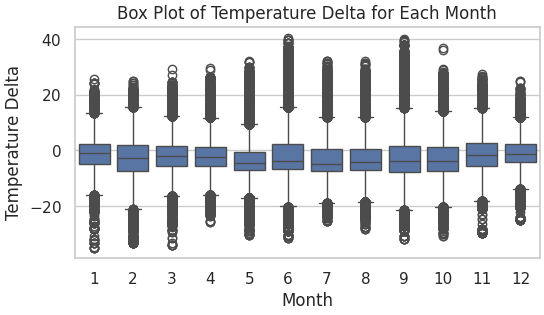

In [20]:
# Assuming 'o_month' is a categorical variable and 'o_temp_delta' is the numerical variable
sns.set(style="whitegrid")  # Optional: Set the style of the plot

# Create a box plot for each month
sns.boxplot(data=data_2, x='o_month', y='o_temp_delta')

# Optional: Add labels and a title
plt.xlabel('Month')
plt.ylabel('Temperature Delta')
plt.title('Box Plot of Temperature Delta for Each Month')

plt.show()

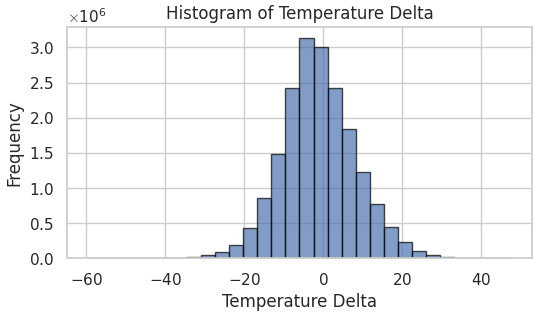

In [21]:
# Create a histogram for 'o_temp_delta'
plt.hist(df['o_temp_delta'], bins=30, edgecolor='black', alpha=0.7)

# Optional: Add labels and a title
plt.xlabel('Temperature Delta')
plt.ylabel('Frequency')
plt.title('Histogram of Temperature Delta')

plt.show()

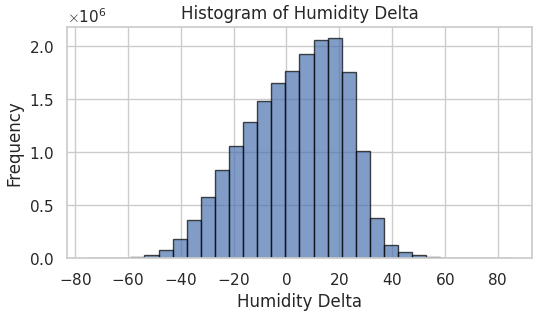

In [22]:
# Create a histogram for 'o_temp_delta'
plt.hist(df['o_humidity_delta'], bins=30, edgecolor='black', alpha=0.7)

# Optional: Add labels and a title
plt.xlabel('Humidity Delta')
plt.ylabel('Frequency')
plt.title('Histogram of Humidity Delta')

plt.show()

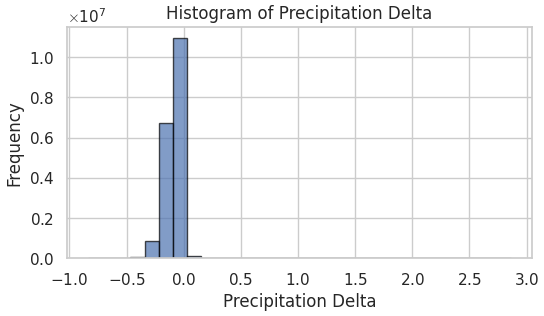

In [23]:
# Create a histogram for 'o_temp_delta'
plt.hist(df['o_precipitation_delta'], bins=30, edgecolor='black', alpha=0.7)

# Optional: Add labels and a title
plt.xlabel('Precipitation Delta')
plt.ylabel('Frequency')
plt.title('Histogram of Precipitation Delta')

plt.show()

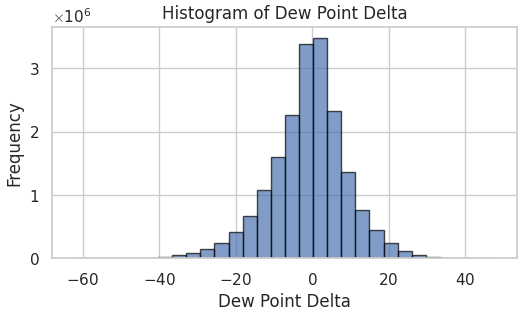

In [24]:
# Create a histogram for 'o_temp_delta'
plt.hist(df['o_dew_point_delta'], bins=30, edgecolor='black', alpha=0.7)

# Optional: Add labels and a title
plt.xlabel('Dew Point Delta')
plt.ylabel('Frequency')
plt.title('Histogram of Dew Point Delta')

plt.show()

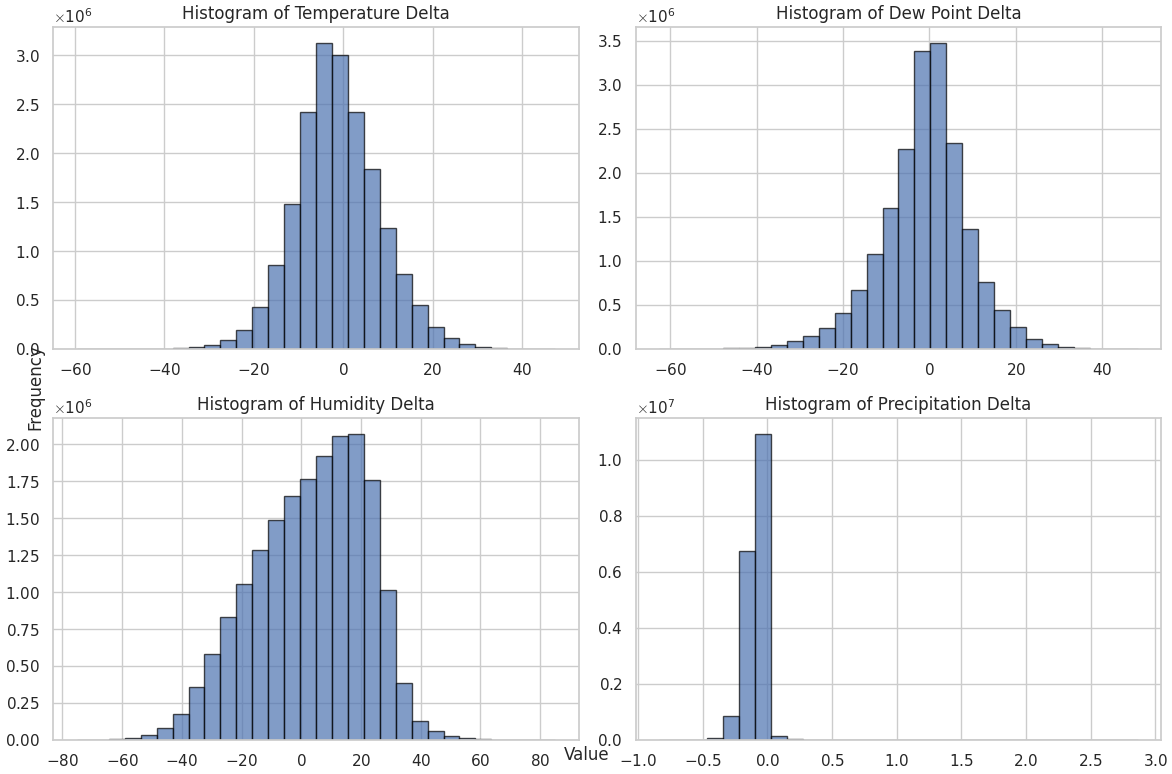

In [25]:
variables = ['o_temp_delta', 'o_dew_point_delta', 'o_humidity_delta', 'o_precipitation_delta']
variable_names = ['Temperature Delta', 'Dew Point Delta', 'Humidity Delta', 'Precipitation Delta']

sns.set(style="whitegrid")  
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

for i, (variable, name) in enumerate(zip(variables, variable_names)):
    axes[i].hist(df[variable], bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Histogram of {name}')

plt.tight_layout()

fig.text(0.5, 0.04, 'Value', ha='center', va='center')
fig.text(0.04, 0.5, 'Frequency', ha='center', va='center', rotation='vertical')

plt.show()

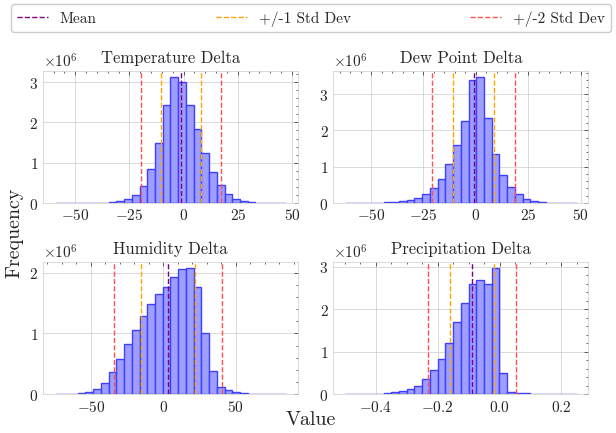

In [87]:
# Assuming these are the numerical variables
variables = ['o_temp_delta', 'o_dew_point_delta', 'o_humidity_delta', 'o_precipitation_delta']
variable_names = ['Temperature Delta', 'Dew Point Delta', 'Humidity Delta', 'Precipitation Delta']

# sns.set(style="whitegrid")

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 4))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Create histograms for each variable in each subplot
for i, (variable, name) in enumerate(zip(variables, variable_names)):
    if variable == 'o_precipitation_delta':
        df_filtered = df.drop(df[(df['o_precipitation_delta'] > 0.25) | (df['o_precipitation_delta'] < -0.5)].index)
        axes[i].hist(df_filtered[variable], bins=30, ec="#3f3fff", linewidth=1, fc="#9e9eff")
        axes[i].set_title(name)
    
        # Draw lines representing +2 and -2 standard deviations
        mean_val = df_filtered[variable].mean()
        std_dev = df_filtered[variable].std()
        axes[i].axvline(mean_val, color='purple', linestyle='dashed', linewidth=1, label='Mean')
        axes[i].axvline(mean_val - std_dev, color='orange', linestyle='dashed', linewidth=1, label='+/-1 Std Dev')
        axes[i].axvline(mean_val + std_dev, color='orange', linestyle='dashed', linewidth=1)
        axes[i].axvline(mean_val - 2 * std_dev, color="#ff5151", linestyle='dashed', linewidth=1, label='+/-2 Std Dev')
        axes[i].axvline(mean_val + 2 * std_dev, color="#ff5151", linestyle='dashed', linewidth=1)
    else:
        axes[i].hist(df[variable], bins=30, ec="#3f3fff", linewidth=1, fc="#9e9eff")
        axes[i].set_title(name)
    
        # Draw lines representing +2 and -2 standard deviations
        mean_val = df[variable].mean()
        std_dev = df[variable].std()
        axes[i].axvline(mean_val - 2 * std_dev, color="#ff5151", linestyle='dashed', linewidth=1)
        axes[i].axvline(mean_val + 2 * std_dev, color="#ff5151", linestyle='dashed', linewidth=1)
        axes[i].axvline(mean_val - std_dev, color='orange', linestyle='dashed', linewidth=1)
        axes[i].axvline(mean_val + std_dev, color='orange', linestyle='dashed', linewidth=1)
        axes[i].axvline(mean_val, color='purple', linestyle='dashed', linewidth=1)
        

plt.tight_layout()

plt.figlegend(frameon=True,
              framealpha=1, bbox_to_anchor=(0, 1, 1, 0), loc="lower left",
              mode="expand", borderaxespad=0, ncol=4)

fig.supxlabel('Value')
fig.supylabel('Frequency', x=-0.01)

plt.savefig("adverse.eps", bbox_inches="tight")

plt.show()

In [41]:
import pandas as pd
from scipy.stats import ttest_ind

# Assuming your data is stored in a DataFrame called 'df'
# Replace 'YourWeatherColumns' with the actual column names

# Calculate the standard deviation of each weather variable
std_dev_temperature = df['o_temperature_2m'].std()
std_dev_precipitation = df['o_precipitation'].std()
std_dev_wind_speed = df['o_wind_speed_10m'].std()
std_dev_cloud_cover = df['o_cloud_cover'].std()

# Define threshold values based on the second and second-to-last standard deviations
threshold_high = 2 * std_dev_temperature
threshold_low = 2 * std_dev_precipitation

# Categorize adverse weather conditions based on thresholds
adverse_condition_group = df[
    (df['o_temperature_2m'] > threshold_high) |
    (df['o_precipitation'] > threshold_low) |
    (df['o_wind_speed_10m'] > threshold_high) |
    (df['o_cloud_cover'] > threshold_low)
]['DepDelayMinutes']

normal_condition_group = df[
    (df['o_temperature_2m'] <= threshold_high) &
    (df['o_precipitation'] <= threshold_low) &
    (df['o_wind_speed_10m'] <= threshold_high) &
    (df['o_cloud_cover'] <= threshold_low)
]['DepDelayMinutes']

# Perform t-test
t_stat, p_value = ttest_ind(adverse_condition_group, normal_condition_group, equal_var=False)

# Print the results
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

# Interpret the results
alpha = 0.05  # Set your desired significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in delays between adverse and normal weather conditions.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in delays between adverse and normal weather conditions.")


T-statistic: 44.615822004554076
P-value: 0.0
Reject the null hypothesis: There is a significant difference in delays between adverse and normal weather conditions.


In [42]:
import pandas as pd
from scipy.stats import ttest_ind

# Assuming your data is stored in a DataFrame called 'df'
# Replace 'YourWeatherColumns' with the actual column names

# Calculate the standard deviation of each weather variable
std_dev_temperature = df['o_temp_delta'].std()
std_dev_precipitation = df['o_precipitation_delta'].std()
std_dev_humidity = df['o_humidity_delta'].std()
std_dev_dew_point = df['o_dew_point_delta'].std()

adverse_condition_group = df[
    (df['o_temp_delta'] >  2*std_dev_temperature) |
    (df['o_temp_delta'] <  (-2*std_dev_temperature))|
    (df['o_precipitation_delta'] > 2*std_dev_precipitation) |
    (df['o_precipitation_delta'] < (-2*std_dev_precipitation)) |
    (df['o_humidity_delta'] > 2*std_dev_humidity) |
    (df['o_humidity_delta'] < (-2*std_dev_humidity)) |
    (df['o_dew_point_delta'] > 2*std_dev_dew_point) |
    (df['o_dew_point_delta'] < (-2*std_dev_dew_point))
]['DepDelayMinutes']

print(adverse_condition_group.count())
normal_condition_group = df[
    (df['o_temp_delta'] <=  2*std_dev_temperature) &
    (df['o_temp_delta'] >= (-2*std_dev_temperature))&
    (df['o_precipitation_delta'] <= 2*std_dev_precipitation)&
    (df['o_precipitation_delta'] >= (-2*std_dev_precipitation))&
    (df['o_humidity_delta'] <= 2*std_dev_humidity) &
    (df['o_humidity_delta'] >= (-2*std_dev_humidity)) &
    (df['o_dew_point_delta'] <= 2*std_dev_dew_point) &
    (df['o_dew_point_delta'] >= (-2*std_dev_dew_point))
]['DepDelayMinutes']

print(normal_condition_group.count())


5334560
13435488


In [43]:

t_stat, p_value = ttest_ind(adverse_condition_group, normal_condition_group, equal_var=False)

# Print the results
print(f'T-statistic: {round(t_stat, 2)}')
print(f'P-value: {round(p_value, 2)}')
alpha = 0.05  # Set your desired significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in delays between adverse and normal weather conditions.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in delays between adverse and normal weather conditions.")

T-statistic: 28.25
P-value: 0.0
Reject the null hypothesis: There is a significant difference in delays between adverse and normal weather conditions.


In [44]:
from scipy.stats import f_oneway

# Choose weather-related categorical variable and the delay variable
# For example, let's consider weather codes
weather_category_variable = 'o_weather_code'
delay_variable = 'DepDelayMinutes'

data = df[[weather_category_variable, delay_variable]].dropna()

groups = [group for name, group in data.groupby(weather_category_variable)]
f_statistic, p_value = f_oneway(*groups)

print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")



F-statistic: [           inf 11120.01213982]
P-value: [0. 0.]


/home/shared/code/my-venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


In [ ]:
!pip install trendypy


In [45]:
# Assuming you want to select 'Column1' and 'Column2'
columns_of_interest = ['FlightDate', 'DepDelayMinutes']

new_df = df[columns_of_interest].copy()
new_df.set_index('FlightDate', inplace=True)


In [46]:
new_df.head()

,DepDelayMinutes
FlightDate,
2017-01-01,31.0
2017-01-02,0.0
2017-01-03,0.0
2017-01-04,0.0
2017-01-05,0.0


In [47]:
new_df_data = data_2[columns_of_interest].copy()
new_df_data.set_index('FlightDate', inplace=True)


In [ ]:
# fig, ax = plt.subplots(figsize=(12, 8))
# sm.graphics.tsa.plot_acf(new_df_data, lags=20, ax=ax);

In [35]:
import numpy as np
import pandas as pd
from sklearn.utils import resample

num_permutations = 10
columns_of_interest = ['DayOfWeek', 'WeatherDelay']
df_original = data_2[columns_of_interest]
permuted_statistics = np.zeros((num_permutations, df_original.shape[1]))

for i in range(num_permutations):
    df_permuted = df_original.copy()
    df_permuted['WeatherDelay'] = resample(df_original['WeatherDelay']).reset_index(drop=True)
    permuted_statistic = df_permuted['DayOfWeek'].mean() - df_permuted['WeatherDelay'].mean()
    permuted_statistics[i, :] = permuted_statistic

observed_statistic = df_original['DayOfWeek'].mean() - df_original['WeatherDelay'].mean()

p_values = np.mean(permuted_statistics >= observed_statistic, axis=0)

print("P-values for each category:")
for i, column in enumerate(columns_of_interest):
    print(f"{column}: {p_values[i]}")


P-values for each category:
DayOfWeek: 0.5
WeatherDelay: 0.5


In [39]:
import numpy as np
import pandas as pd
from sklearn.utils import resample

# Set the number of permutations
num_permutations = 1000

# Define columns of interest
columns_of_interest = ['WeatherDelay', 'OriginState']  # Adjust 'OriginState' or 'DestState' as needed

# Create a new DataFrame with relevant columns
df_original = df[columns_of_interest].dropna()

# Calculate observed statistic
observed_statistic = df_original.groupby('OriginState')['WeatherDelay'].mean().diff().abs().max()

# Initialize storage for permuted statistics
permuted_statistics = np.zeros(num_permutations)

# Permutation test loop
for i in range(num_permutations):
    # Permute the 'WeatherDelay' column
    df_permuted = df_original.copy()
    df_permuted['WeatherDelay'] = resample(df_original['WeatherDelay']).reset_index(drop=True)
    
    # Calculate the statistic of interest
    permuted_statistic = df_permuted.groupby('OriginState')['WeatherDelay'].mean().diff().abs().max()
    permuted_statistics[i] = permuted_statistic

# Calculate p-value
p_value = np.mean(permuted_statistics >= observed_statistic)

# Print the result
print(f"P-value: {p_value}")


P-value: 0.001


In [53]:
import numpy as np
import pandas as pd
from sklearn.utils import resample

# Set the number of permutations
num_permutations = 1000

columns_of_interest = ['WeatherDelay', 'Origin']  # Adjust 'OriginState' or 'DestState' as needed

# Create a new DataFrame with relevant columns
df_original = df[columns_of_interest].dropna();
 

# Calculate observed statistic
observed_statistic = df_original.groupby('Origin')['WeatherDelay'].mean().diff().abs().max()

# Initialize storage for permuted statistics
permuted_statistics = np.zeros(num_permutations)

# Permutation test loop
for i in range(num_permutations):
    # Permute the 'WeatherDelay' column
    df_permuted = df_original.copy()
    df_permuted['WeatherDelay'] = resample(df_original['WeatherDelay']).reset_index(drop=True)
    
    # Calculate the statistic of interest
    permuted_statistic = df_permuted.groupby('Origin')['WeatherDelay'].mean().diff().abs().max()
    permuted_statistics[i] = permuted_statistic

# Calculate p-value
p_value = np.mean(permuted_statistics >= observed_statistic)

# Print the result
print(f"P-value: {p_value}")


P-value: 0.012


In [56]:
import numpy as np
import pandas as pd
from sklearn.utils import resample

# Set the number of permutations
num_permutations = 1000

# Define columns of interest
columns_of_interest = ['WeatherDelay', 'FlightDate', 'Origin']  # Include 'FlightDate' for temporal analysis

# Create a new DataFrame with relevant columns
df_original = df[columns_of_interest].dropna()

# Convert 'FlightDate' to datetime if not already
df_original['FlightDate'] = pd.to_datetime(df_original['FlightDate'])

# Calculate observed statistic
observed_statistic = df_original.groupby('FlightDate')['WeatherDelay'].mean().diff().abs().max()

# Initialize storage for permuted statistics
permuted_statistics = np.zeros(num_permutations)

# Permutation test loop
for i in range(num_permutations):
    # Permute the 'WeatherDelay' column
    df_permuted = df_original.copy()
    df_permuted['WeatherDelay'] = resample(df_original['WeatherDelay']).reset_index(drop=True)
    
    # Calculate the statistic of interest
    permuted_statistic = df_permuted.groupby('FlightDate')['WeatherDelay'].mean().diff().abs().max()
    permuted_statistics[i] = permuted_statistic

# Calculate p-value
p_value = np.mean(permuted_statistics >= observed_statistic)

# Print the result
print(f"P-value: {p_value}")


P-value: 0.031


In [57]:
import numpy as np
import pandas as pd
from sklearn.utils import resample

# Set the number of permutations
num_permutations = 1000

# Define columns of interest
columns_of_interest = ['WeatherDelay', 'NASDelay', 'FlightDate', 'Origin']  # Include 'FlightDate' for temporal analysis

# Create a new DataFrame with relevant columns
df_original = df[columns_of_interest].dropna()

# Convert 'FlightDate' to datetime if not already
df_original['FlightDate'] = pd.to_datetime(df_original['FlightDate'])

# Calculate the combined delay by adding WeatherDelay and NASDelay
df_original['CombinedDelay'] = df_original['WeatherDelay'] + df_original['NASDelay']

# Calculate observed statistic for CombinedDelay
observed_statistic_combined = df_original.groupby('FlightDate')['CombinedDelay'].mean().diff().abs().max()

# Initialize storage for permuted statistics
permuted_statistics_combined = np.zeros(num_permutations)

# Permutation test loop for CombinedDelay
for i in range(num_permutations):
    # Permute the 'CombinedDelay' column
    df_permuted = df_original.copy()
    df_permuted['CombinedDelay'] = resample(df_original['CombinedDelay']).reset_index(drop=True)
    
    # Calculate the statistic of interest for CombinedDelay
    permuted_statistic_combined = df_permuted.groupby('FlightDate')['CombinedDelay'].mean().diff().abs().max()
    permuted_statistics_combined[i] = permuted_statistic_combined

# Calculate p-value for CombinedDelay
p_value_combined = np.mean(permuted_statistics_combined >= observed_statistic_combined)

# Print the result
print(f"P-value for CombinedDelay: {p_value_combined}")


P-value for CombinedDelay: 0.029
